# Task 4: Loan Default Risk with Business Cost Optimization

**Internship Project – Data Science & Analytics**  
**Organization:** DevelopersHub Corporation  
**Intern:** Ashna Imtiaz 

---

## Objective  
The goal of this task is to **predict the likelihood of loan default** using machine learning models and to **optimize the classification threshold** by incorporating **business cost analysis**. 

---

## 📂 Dataset  
- **Source:** Home Credit Default Risk Dataset  
- **Type:** Binary classification (Default vs. No Default)  
---

## Instructions
1. **Data Cleaning & Preprocessing** – Handle missing values, categorical encoding, feature scaling.  
2. **Model Training** – Train classification models such as:  
   - Logistic Regression  
   - CatBoost  
   - Other advanced models (optional)  
3. **Cost-Benefit Analysis** – Define monetary values for False Positives (FP) and False Negatives (FN).  
4. **Threshold Optimization** – Adjust decision threshold to minimize **total business cost** rather than maximizing accuracy alone.  

---


In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

from sklearn.metrics import (
                        accuracy_score, 
                        classification_report, 
                        confusion_matrix,
                        precision_recall_curve,
                        roc_auc_score,
                        roc_curve
                    )
# for custom cost functions
from functools import partial

# Load the Dataset

In [212]:
train = pd.read_csv("/kaggle/input/home-credit-default-risk/application_train.csv")
test = pd.read_csv("/kaggle/input/home-credit-default-risk/application_test.csv")

train.shape, test.shape

((307511, 122), (48744, 121))

In [213]:
# do the EDA: 
train = pd.read_csv("home-credit-default-risk/application_train.csv")
test = pd.read_csv("home-credit-default-risk/application_test.csv")

train.shape, test.shape

((307511, 122), (48744, 121))

# Exploratory Data Analysis (EDA)

In [214]:
# Basic dataset info
print("Training Data Shape:", train.shape)
print("Test Data Shape:", test.shape)


Training Data Shape: (307511, 122)
Test Data Shape: (48744, 121)


In [215]:
import warnings
warnings.filterwarnings('ignore')

In [216]:
# First look at train
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [217]:
# Missing values count and percentage
missing_values = train.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_values / len(train)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Missing %': missing_percent
})
print("There are", len(missing_df[missing_df['Missing Values'] > 0]), " columns having missing values")
missing_df[missing_df['Missing Values'] > 0].head(20)  # Top 20


There are 67  columns having missing values


,Missing Values,Missing %
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953
LIVINGAPARTMENTS_MEDI,210199,68.354953


## Target Variable Distribution

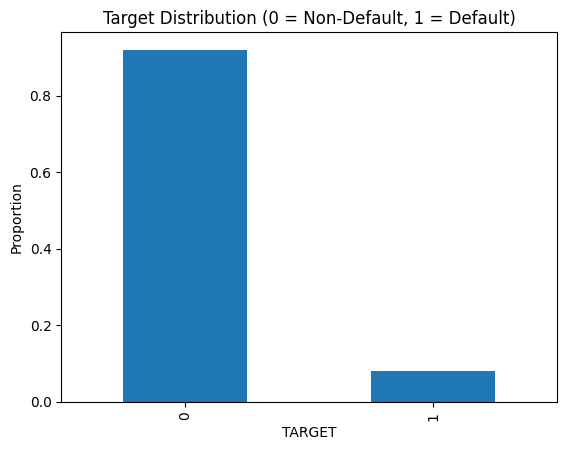

In [218]:
# Target column = 'TARGET'
train['TARGET'].value_counts(normalize=True).plot(kind='bar')
plt.title("Target Distribution (0 = Non-Default, 1 = Default)")
plt.xlabel("TARGET")
plt.ylabel("Proportion")
plt.show()


In [219]:
train.describe().T.head(10)  # First 10 numerical stats


,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511.0,278180.518577,102790.175348,100002.00000,189145.500000,278202.00000,367142.500000,4.562550e+05
TARGET,307511.0,0.080729,0.272419,0.00000,0.000000,0.00000,0.000000,1.000000e+00
CNT_CHILDREN,307511.0,0.417052,0.722121,0.00000,0.000000,0.00000,1.000000,1.900000e+01
AMT_INCOME_TOTAL,307511.0,168797.919297,237123.146279,25650.00000,112500.000000,147150.00000,202500.000000,1.170000e+08
AMT_CREDIT,307511.0,599025.999706,402490.776996,45000.00000,270000.000000,513531.00000,808650.000000,4.050000e+06
AMT_ANNUITY,307499.0,27108.573909,14493.737315,1615.50000,16524.000000,24903.00000,34596.000000,2.580255e+05
AMT_GOODS_PRICE,307233.0,538396.207429,369446.460540,40500.00000,238500.000000,450000.00000,679500.000000,4.050000e+06
REGION_POPULATION_RELATIVE,307511.0,0.020868,0.013831,0.00029,0.010006,0.01885,0.028663,7.250800e-02
DAYS_BIRTH,307511.0,-16036.995067,4363.988632,-25229.00000,-19682.000000,-15750.00000,-12413.000000,-7.489000e+03
DAYS_EMPLOYED,307511.0,63815.045904,141275.766519,-17912.00000,-2760.000000,-1213.00000,-289.000000,3.652430e+05


#### Correlation with Target

In [220]:
# Correlation with TARGET (numeric only)
num_features = train.select_dtypes(include='number')
corr = num_features.corr()['TARGET'].sort_values(ascending=False)
corr.head(15), corr.tail(15)

(TARGET                         1.000000
 DAYS_BIRTH                     0.078239
 REGION_RATING_CLIENT_W_CITY    0.060893
 REGION_RATING_CLIENT           0.058899
 DAYS_LAST_PHONE_CHANGE         0.055218
 DAYS_ID_PUBLISH                0.051457
 REG_CITY_NOT_WORK_CITY         0.050994
 FLAG_EMP_PHONE                 0.045982
 REG_CITY_NOT_LIVE_CITY         0.044395
 FLAG_DOCUMENT_3                0.044346
 DAYS_REGISTRATION              0.041975
 OWN_CAR_AGE                    0.037612
 LIVE_CITY_NOT_WORK_CITY        0.032518
 DEF_30_CNT_SOCIAL_CIRCLE       0.032248
 DEF_60_CNT_SOCIAL_CIRCLE       0.031276
 Name: TARGET, dtype: float64,
 LIVINGAREA_MEDI              -0.032739
 LIVINGAREA_AVG               -0.032997
 FLOORSMIN_MEDI               -0.033394
 FLOORSMIN_AVG                -0.033614
 ELEVATORS_MEDI               -0.033863
 ELEVATORS_AVG                -0.034199
 REGION_POPULATION_RELATIVE   -0.037227
 AMT_GOODS_PRICE              -0.039645
 FLOORSMAX_MODE               -0.0

In [221]:
# column type 
train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [222]:
# Unique entries of type object columns
print(f"There are {len(train.select_dtypes('object').columns.tolist())} Categorical Columns.")
train.select_dtypes('object').apply(pd.Series.nunique, axis=0)

There are 16 Categorical Columns.


NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

# Data Cleaning

In [223]:
# Standardize the columns names
train.columns = [col.lower().replace(" ", "_") for col in train.columns]

In [224]:
test.columns = [col.lower().replace(" ", "_") for col in test.columns]

In [225]:
train.columns

Index(['sk_id_curr', 'target', 'name_contract_type', 'code_gender',
       'flag_own_car', 'flag_own_realty', 'cnt_children', 'amt_income_total',
       'amt_credit', 'amt_annuity',
       ...
       'flag_document_18', 'flag_document_19', 'flag_document_20',
       'flag_document_21', 'amt_req_credit_bureau_hour',
       'amt_req_credit_bureau_day', 'amt_req_credit_bureau_week',
       'amt_req_credit_bureau_mon', 'amt_req_credit_bureau_qrt',
       'amt_req_credit_bureau_year'],
      dtype='object', length=122)

In [226]:
# Separate target
y_train = train["target"]
X_train = train.drop(columns=["target"])


Drop highly missing columns

In [227]:
train.columns[train.isnull().mean() > 0.60]

Index(['own_car_age', 'years_build_avg', 'commonarea_avg', 'floorsmin_avg',
       'livingapartments_avg', 'nonlivingapartments_avg', 'years_build_mode',
       'commonarea_mode', 'floorsmin_mode', 'livingapartments_mode',
       'nonlivingapartments_mode', 'years_build_medi', 'commonarea_medi',
       'floorsmin_medi', 'livingapartments_medi', 'nonlivingapartments_medi',
       'fondkapremont_mode'],
      dtype='object')

In [228]:
train.head()

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,...,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [229]:
# Separate target
y_train = train["target"]

In [230]:
# Align train and test columns
X_train, X_test = X_train.align(test, join="inner", axis=1)

In [231]:
train['target'] = y_train

In [232]:
train.shape, test.shape

((307511, 122), (48744, 121))

In [233]:
# Separate target
y_train = train["target"]
X_train = train.drop(columns=["target"])
X_test  = test.copy()


In [234]:
X_train.shape, X_test.shape, y_train.shape

((307511, 121), (48744, 121), (307511,))

In [235]:
# Drop columns with >60% missing values (using combined data to align both)
combined = pd.concat([X_train, X_test], axis=0)
missing_ratio = combined.isnull().mean()
drop_cols = missing_ratio[missing_ratio > 0.6].index

In [236]:
X_train = X_train.drop(columns=drop_cols)
X_test  = X_test.drop(columns=drop_cols)

# Impute Missing Values

In [237]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


# Separate categorical & numerical columns
num_cols = X_train.select_dtypes(include=[np.number]).columns
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns


# Numerical pipeline: impute with median + scale
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical pipeline: impute with most frequent + one-hot encode
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])


# Preprocessing Pipeline

In [238]:
# Build preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols),
        ("cat", cat_transformer, cat_cols)
    ]
)

In [239]:
# Create final pipeline 
pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

# Fit the pipeline on train and transform both train+test
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed  = pipeline.transform(X_test)

X_train_processed.shape, X_test_processed.shape

((307511, 225), (48744, 225))

In [240]:
y_train.shape

(307511,)

## Split the data into Training and validation set

In [241]:
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train_processed, y_train, test_size=0.2, random_state=42, stratify=y_train
)

### Oversampling the minority class

In [242]:
train_df = pd.DataFrame(X_train_split)
train_df['target'] = y_train_split.values

# Separate majority and minority classes
majority = train_df[train_df.target == 0]
minority = train_df[train_df.target == 1]

# Upsample minority class
minority_upsampled = minority.sample(len(majority), replace=True, random_state=42)

#Combine back
balanced_df = pd.concat([majority, minority_upsampled])

# Shuffle 
balanced_df = balanced_df.sample(frac=1, random_state=42)

X_train_balanced = balanced_df.drop(columns='target').values
y_train_balanced = balanced_df['target']

In [243]:
print("Before:", y_train.value_counts())
print("After:", y_train_balanced.value_counts())

Before: target
0    282686
1     24825
Name: count, dtype: int64
After: target
0    226148
1    226148
Name: count, dtype: int64


## Train Logistic Regression

In [244]:

# Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_balanced, y_train_balanced)   # use balanced labels

LogisticRegression(max_iter=1000, random_state=42)

In [245]:
X_val.shape

(61503, 225)

In [246]:
# Predictions
y_pred = log_reg.predict(X_val)
y_proba = log_reg.predict_proba(X_val)[:, 1]

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_val, y_proba))


Confusion Matrix:
 [[39078 17460]
 [ 1607  3358]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.69      0.80     56538
           1       0.16      0.68      0.26      4965

    accuracy                           0.69     61503
   macro avg       0.56      0.68      0.53     61503
weighted avg       0.90      0.69      0.76     61503

ROC-AUC Score: 0.7482297017250863


# ***Custom cost function*** 

In [247]:
# --- Custom cost function ---
def custom_cost(y_true, y_pred, cost_fn=10, cost_fp=1):
    """
    Penalizes False Negatives (cost_fn) and False Positives (cost_fp).
    """
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    cost = (cost_fn * fn) + (cost_fp * fp)
    return cost, cm

# Apply custom cost function
cost, cm = custom_cost(y_val, y_pred, cost_fn=10, cost_fp=1)

print("\nCustom Cost Function:")
print("Confusion Matrix:\n", cm)
print(f"Total Cost (FN*{10} + FP*{1}): {cost}")



Custom Cost Function:
Confusion Matrix:
 [[39078 17460]
 [ 1607  3358]]
Total Cost (FN*10 + FP*1): 33530


In [248]:
from sklearn.metrics import confusion_matrix

def custom_cost_function(y_true, y_pred, fn_penalty=5, fp_penalty=1):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = fn * fn_penalty + fp * fp_penalty
    return cost


In [249]:
# Predict on validation data
y_val_pred = log_reg.predict(X_val)

# Standard metrics
from sklearn.metrics import classification_report, accuracy_score
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

# Custom cost
cost = custom_cost_function(y_val, y_val_pred, fn_penalty=5, fp_penalty=1)
print("Custom Cost (FP=1, FN=5):", cost)


Validation Accuracy: 0.689982602474676
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     56538
           1       0.16      0.68      0.26      4965

    accuracy                           0.69     61503
   macro avg       0.56      0.68      0.53     61503
weighted avg       0.90      0.69      0.76     61503

Custom Cost (FP=1, FN=5): 25495


In [252]:
# Initialize CatBoost
cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    eval_metric='AUC',
    random_seed=42,
    verbose=100,
    auto_class_weights='Balanced'
)

# Train on the balanced data
cat_model.fit(X_train_processed, y_train, eval_set=(X_val, y_val), use_best_model=True)

0:	test: 0.7020737	best: 0.7020737 (0)	total: 105ms	remaining: 52.2s
100:	test: 0.7562523	best: 0.7562523 (100)	total: 8.11s	remaining: 32s
200:	test: 0.7649950	best: 0.7649950 (200)	total: 15.8s	remaining: 23.5s
300:	test: 0.7724291	best: 0.7724291 (300)	total: 23.5s	remaining: 15.5s
400:	test: 0.7803902	best: 0.7803902 (400)	total: 31s	remaining: 7.66s
499:	test: 0.7875507	best: 0.7875507 (499)	total: 38.8s	remaining: 0us

bestTest = 0.7875506628
bestIteration = 499



In [251]:
# Predictions
y_val_pred = cat_model.predict(X_val)

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:\n", cm)

# Custom cost function
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]
TN = cm[0][0]

cost = (10 * FP) + (50 * FN)  # adjust penalties as needed
print("Custom Cost:", cost)


Confusion Matrix:
 [[40311 16227]
 [ 1421  3544]]
Custom Cost: 233320


In [253]:
cat_model2 = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    eval_metric='F1',
    random_seed=42,
    verbose=100,
    auto_class_weights='Balanced'
)


In [254]:
cat_model.fit(X_train_processed, y_train, eval_set=(X_val, y_val), use_best_model=True)


0:	test: 0.7020737	best: 0.7020737 (0)	total: 99.1ms	remaining: 49.5s
100:	test: 0.7562523	best: 0.7562523 (100)	total: 8.1s	remaining: 32s
200:	test: 0.7649950	best: 0.7649950 (200)	total: 15.7s	remaining: 23.4s
300:	test: 0.7724291	best: 0.7724291 (300)	total: 23.4s	remaining: 15.5s
400:	test: 0.7803902	best: 0.7803902 (400)	total: 31s	remaining: 7.65s
499:	test: 0.7875507	best: 0.7875507 (499)	total: 38.8s	remaining: 0us

bestTest = 0.7875506628
bestIteration = 499



In [255]:
y_proba = cat_model.predict_proba(X_val)[:,1]
from sklearn.metrics import confusion_matrix

for thr in [0.3, 0.4, 0.5, 0.6]:
    preds = (y_proba >= thr).astype(int)
    print(f"Threshold: {thr}")
    print(confusion_matrix(y_val, preds))


Threshold: 0.3
[[21250 35288]
 [  351  4614]]
Threshold: 0.4
[[31594 24944]
 [  784  4181]]
Threshold: 0.5
[[40311 16227]
 [ 1421  3544]]
Threshold: 0.6
[[47205  9333]
 [ 2225  2740]]


In [259]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Get predicted probabilities (for positive class = 1)
y_pred_proba = cat_model.predict_proba(X_val)[:, 1]

# Define your custom cost function
def custom_cost(y_true, y_pred, fp_cost=5, fn_cost=100):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp * fp_cost + fn * fn_cost

# Sweep thresholds
thresholds = np.arange(0.1, 0.91, 0.05)  # from 0.1 to 0.9 step 0.05
results = []

for thr in thresholds:
    y_pred = (y_pred_proba >= thr).astype(int)
    cost = custom_cost(y_val, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    results.append((thr, cost, tn, fp, fn, tp))

# Print results
print("Threshold | Cost   | TN    FP    FN    TP")
for r in results:
    print(f"{r[0]:.2f}      | {r[1]:6d} | {r[2]:5d} {r[3]:5d} {r[4]:5d} {r[5]:5d}")


Threshold | Cost   | TN    FP    FN    TP
0.10      | 273410 |  1876 54662     1  4964
0.15      | 257920 |  5414 51124    23  4942
0.20      | 240455 | 10187 46351    87  4878
0.25      | 222700 | 15718 40820   186  4779
0.30      | 211540 | 21250 35288   351  4614
0.35      | 203410 | 26616 29922   538  4427
0.40      | 203120 | 31594 24944   784  4181
0.45      | 208740 | 36230 20308  1072  3893
0.50      | 223235 | 40311 16227  1421  3544
0.55      | 243535 | 43951 12587  1806  3159
0.60      | 269165 | 47205  9333  2225  2740
0.65      | 300660 | 49946  6592  2677  2288
0.70      | 335515 | 52155  4383  3136  1829
0.75      | 373780 | 53882  2656  3605  1360
0.80      | 413280 | 55142  1396  4063   902
0.85      | 450705 | 56017   521  4481   484
0.90      | 481765 | 56445    93  4813   152


In [267]:
# Initialize CatBoost
cat_model2 = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    eval_metric='AUC',
    random_seed=42,
    verbose=100,
    auto_class_weights='Balanced'
)

# Train on training data
cat_model2.fit(X_train_split, y_train_split, 
               eval_set=(X_val, y_val), 
               use_best_model=True)




0:	test: 0.7031366	best: 0.7031366 (0)	total: 95.2ms	remaining: 47.5s
100:	test: 0.7508897	best: 0.7508897 (100)	total: 6.91s	remaining: 27.3s
200:	test: 0.7559718	best: 0.7559718 (200)	total: 13.5s	remaining: 20.2s
300:	test: 0.7593894	best: 0.7593894 (300)	total: 20.3s	remaining: 13.4s
400:	test: 0.7615599	best: 0.7616030 (395)	total: 26.9s	remaining: 6.65s
499:	test: 0.7622490	best: 0.7622490 (499)	total: 33.5s	remaining: 0us

bestTest = 0.7622489586
bestIteration = 499



In [268]:
# Now you can safely predict probabilities
y_pred_proba = cat_model2.predict_proba(X_val)[:, 1]

# Apply threshold = 0.35
y_pred = (y_pred_proba >= 0.35).astype(int)

# Confusion matrix & report
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[26651 29887]
 [  667  4298]]
              precision    recall  f1-score   support

           0       0.98      0.47      0.64     56538
           1       0.13      0.87      0.22      4965

    accuracy                           0.50     61503
   macro avg       0.55      0.67      0.43     61503
weighted avg       0.91      0.50      0.60     61503



In [273]:
y_proba = cat_model2.predict_proba(X_val)[:,1]
from sklearn.metrics import confusion_matrix

for thr in [0.3, 0.4, 0.5, 0.6]:
    preds = (y_proba >= thr).astype(int)
    print(f"Threshold: {thr}")
    print(confusion_matrix(y_val, preds))
    print(classification_report(y_val, preds))


Threshold: 0.3
[[21360 35178]
 [  471  4494]]
              precision    recall  f1-score   support

           0       0.98      0.38      0.55     56538
           1       0.11      0.91      0.20      4965

    accuracy                           0.42     61503
   macro avg       0.55      0.64      0.37     61503
weighted avg       0.91      0.42      0.52     61503

Threshold: 0.4
[[31603 24935]
 [  954  4011]]
              precision    recall  f1-score   support

           0       0.97      0.56      0.71     56538
           1       0.14      0.81      0.24      4965

    accuracy                           0.58     61503
   macro avg       0.55      0.68      0.47     61503
weighted avg       0.90      0.58      0.67     61503

Threshold: 0.5
[[40228 16310]
 [ 1594  3371]]
              precision    recall  f1-score   support

           0       0.96      0.71      0.82     56538
           1       0.17      0.68      0.27      4965

    accuracy                           0.71 

In [274]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Define your false positive / false negative costs
cost_fp = 10   # Example: cost for incorrectly approving a default
cost_fn = 50   # Example: cost for missing a default

# Probabilities from your trained CatBoost on validation set
y_proba = cat_model2.predict_proba(X_val)[:, 1]

# Thresholds to evaluate
thresholds = np.arange(0.30, 0.61, 0.01)  # 0.30 to 0.60

print("Threshold | Cost   | TN    FP    FN    TP")
for thr in thresholds:
    preds = (y_proba >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val, preds).ravel()
    total_cost = fp * cost_fp + fn * cost_fn
    print(f"{thr:.2f}      | {total_cost} | {tn}  {fp}  {fn}  {tp}")


Threshold | Cost   | TN    FP    FN    TP
0.30      | 375330 | 21360  35178  471  4494
0.31      | 366570 | 22406  34132  505  4460
0.32      | 357720 | 23491  33047  545  4420
0.33      | 349060 | 24587  31951  591  4374
0.34      | 340670 | 25596  30942  625  4340
0.35      | 332220 | 26651  29887  667  4298
0.36      | 324860 | 27667  28871  723  4242
0.37      | 317740 | 28674  27864  782  4183
0.38      | 311010 | 29642  26896  841  4124
0.39      | 303730 | 30630  25908  893  4072
0.40      | 297050 | 31603  24935  954  4011
0.41      | 290820 | 32551  23987  1019  3946
0.42      | 285270 | 33401  23137  1078  3887
0.43      | 278770 | 34371  22167  1142  3823
0.44      | 272090 | 35299  21239  1194  3771
0.45      | 266720 | 36141  20397  1255  3710
0.46      | 261560 | 37022  19516  1328  3637
0.47      | 257050 | 37818  18720  1397  3568
0.48      | 251860 | 38642  17896  1458  3507
0.49      | 246620 | 39476  17062  1520  3445
0.50      | 242800 | 40228  16310  1594  3371
0.5

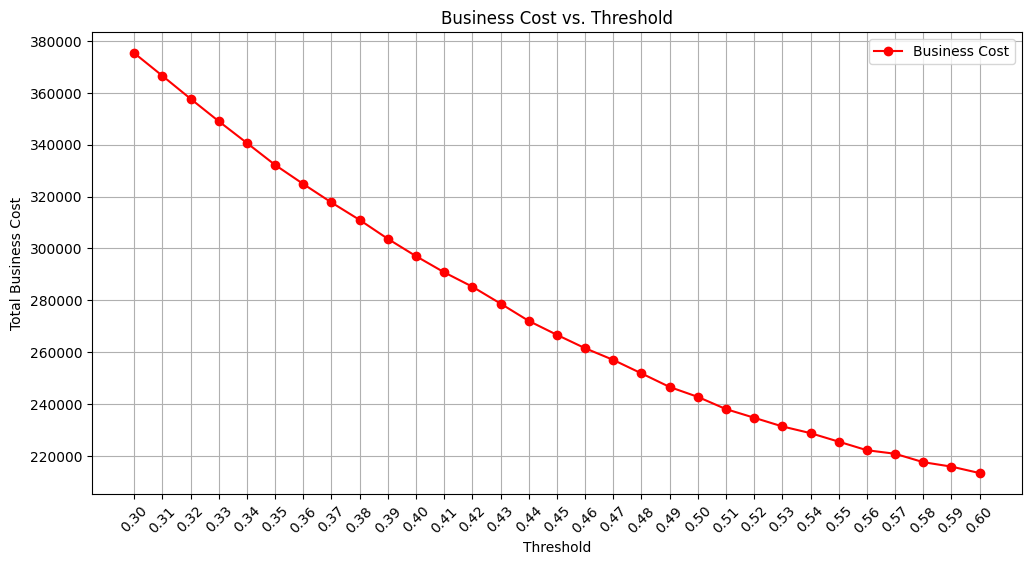

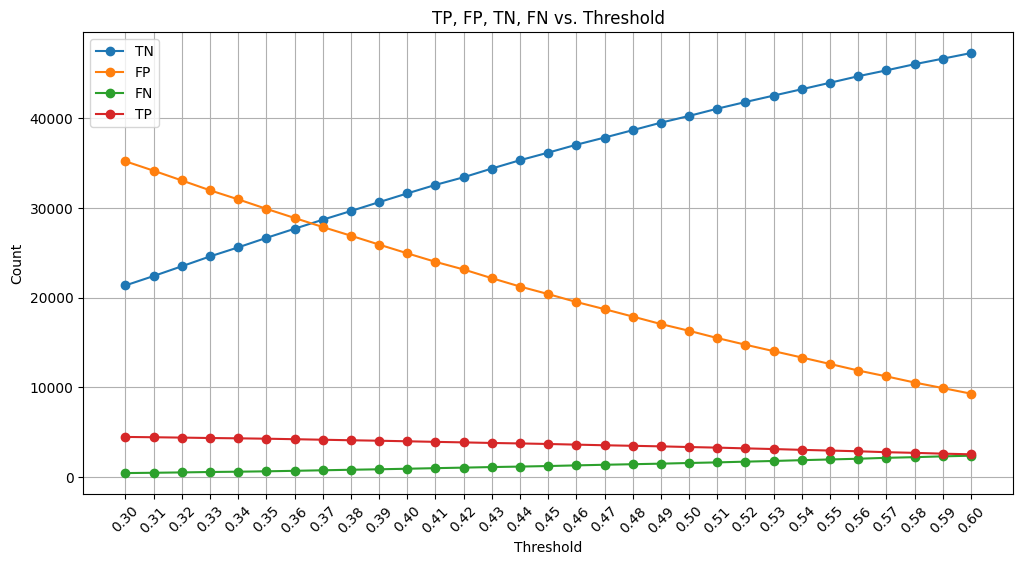

In [277]:
import matplotlib.pyplot as plt

# Thresholds
thresholds = [round(x/100,2) for x in range(30, 61)]  # 0.30 to 0.60

# Metrics
costs = [375330,366570,357720,349060,340670,332220,324860,317740,311010,303730,
         297050,290820,285270,278770,272090,266720,261560,257050,251860,246620,
         242800,238090,234760,231410,228820,225540,222240,220880,217630,215920,213430]

TN = [21360,22406,23491,24587,25596,26651,27667,28674,29642,30630,31603,32551,33401,
      34371,35299,36141,37022,37818,38642,39476,40228,41034,41777,42492,43201,43919,
      44649,45300,45985,46601,47225]

FP = [35178,34132,33047,31951,30942,29887,28871,27864,26896,25908,24935,23987,23137,
      22167,21239,20397,19516,18720,17896,17062,16310,15504,14761,14046,13337,12619,
      11889,11238,10553,9937,9313]

FN = [471,505,545,591,625,667,723,782,841,893,954,1019,1078,1142,1194,1255,1328,1397,
      1458,1520,1594,1661,1743,1819,1909,1987,2067,2170,2242,2331,2406]

TP = [4494,4460,4420,4374,4340,4298,4242,4183,4124,4072,4011,3946,3887,3823,3771,3710,
      3637,3568,3507,3445,3371,3304,3222,3146,3056,2978,2898,2795,2723,2634,2559]

plt.figure(figsize=(12,6))
plt.plot(thresholds, costs, marker='o', label='Business Cost', color='red')
plt.title('Business Cost vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Total Business Cost')
plt.grid(True)
plt.xticks(thresholds, rotation=45)
plt.legend()
plt.show()

# Optional: plot TP, FP, TN, FN curves on the same figure
plt.figure(figsize=(12,6))
plt.plot(thresholds, TN, marker='o', label='TN')
plt.plot(thresholds, FP, marker='o', label='FP')
plt.plot(thresholds, FN, marker='o', label='FN')
plt.plot(thresholds, TP, marker='o', label='TP')
plt.title('TP, FP, TN, FN vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Count')
plt.grid(True)
plt.xticks(thresholds, rotation=45)
plt.legend()
plt.show()


# highlights the threshold with minimum business cost

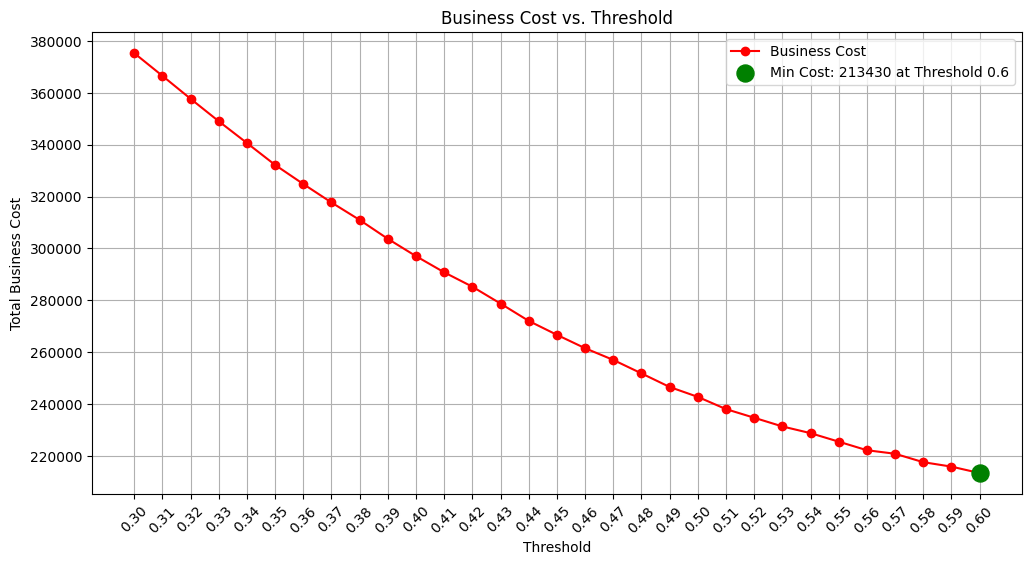

In [278]:
import matplotlib.pyplot as plt
import numpy as np

# Thresholds
thresholds = np.round(np.arange(0.30, 0.61, 0.01), 2)

# Business cost
costs = [375330,366570,357720,349060,340670,332220,324860,317740,311010,303730,
         297050,290820,285270,278770,272090,266720,261560,257050,251860,246620,
         242800,238090,234760,231410,228820,225540,222240,220880,217630,215920,213430]

# Find minimum cost and corresponding threshold
min_cost = min(costs)
best_threshold = thresholds[costs.index(min_cost)]

plt.figure(figsize=(12,6))
plt.plot(thresholds, costs, marker='o', label='Business Cost', color='red')
plt.scatter(best_threshold, min_cost, color='green', s=150, zorder=5, label=f'Min Cost: {min_cost} at Threshold {best_threshold}')
plt.title('Business Cost vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Total Business Cost')
plt.grid(True)
plt.xticks(thresholds, rotation=45)
plt.legend()
plt.show()
